Spatial Correlation between sea surface temperature anomaly and sea surface height anomaly
===========================
#### Author: Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>
#### Date: 12/13/2021
#### Modified by: Dean Henze <dean.c.henze@jpl.nasa.gov> (10/26/2023)

***Any functions below which are duplicated from Jinbo's originals have been modified .***

This notebook centers around the `spatial_corrmap()` fxn, which will create a 2D lat, lon map of spatial correlations between sea surface height (SSH) and sea surface temperature (SST), both hosted on PO.DAAC. The SSH dataset is shortname SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and the SST dataset is shortname MW_OI-REMSS-L4-GLOB-v5.0.

At each gridpoint, the spatial correlation is computed over a lat, lon window of size 2*lat_halfwin x 2*lon_halfwin. This is done for each gridpoint in the datasets. Spatial correlation is computed from the SSH, SST anomalies, which are computed in turn as the deviations from a fitted 2D surface over the window (a new 2D surface is fitted for each window around each gridpoint).

#### Data sets
* SSH - SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205. One file every 5 days, timestamped at noon UTC.
* SST

#### Current Status
* Code is in a state where the spatial_corrmap() function can be tested with Coiled functions. The current estimated time for running spatial_corrmap() on a single SSH-SST file-pair at full resolution is ~1 hour. Currently working to reduce this time.
* Can override manual scaling and explicitly ask for a certiain number of VM's with the command
  ```
  func.cluster.scale(200)
  ```
  Then can go back to adaptive scaling "auto-pilot" with the command
  ```
  func.cluster.adapt(minimum=X, maximum=Y)
  ```

In [1]:
import time
from matplotlib import pylab as plt
import xarray as xr
import numpy as np
from numpy import zeros,arange
from scipy.optimize import leastsq
import numpy as np
import sys
import os
import tempfile
import earthaccess
import coiled

In [2]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=False,
    display_expand_data=True,
)

# Define functions

In [3]:
def load_sst_ssh(granule_ssh):
    """
    Return data for a single file each of SSH and SST on the same day. 
    Input arg is SSH granule info (earthaccess.results.DataGranule object) 
    for a file from the SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 
    collection. Output is SLA data from the SSH granule along with SST data from the 
    MW_OI-REMSS-L4-GLOB-v5.0 collection, at timestamp noon UTC of the same day. 
    Returns ssh, sst as xarray.DataArray's.    
    """  
    # Get SLA variable from file, loaded fully into local memory:
    ssh = xr.load_dataset(earthaccess.open([granule_ssh])[0])['SLA'][0,...]
    
    # Get SST variable from SST file on same day as ssh_fn and at noon. Again, fully loaded into local memory:
    date = granule_ssh['umm']['GranuleUR'].split('_')[-1][:8]
    s3path_sst = 's3://podaac-ops-cumulus-protected/MW_OI-REMSS-L4-GLOB-v5.0/%s120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc'%date
    sst = xr.load_dataset(earthaccess.open([s3path_sst], provider='POCLOUD')[0])['analysed_sst'][0,...]
    
    return ssh, sst

In [4]:
def anomaly(lon, lat, p):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a 2D surface 
    to the data and taking the anomaly as the difference between each data point 
    and the surface. 
    
    This is mostly a wrapper for fit2Dsurf() which does the anomaly calculation. 
    This wrapper could be extended e.g. to take inputs with various shapes and 
    reformat them to work with fit2Dsurf(), but curretly has basic functionality.

    Inputs
    ------
    lon, lat: 1D array-like
        Longitude and latitude arrays, or more generally, the x, y coordinates (don't 
        need to have units of degrees e.g.).
    p: 2D array-like
        Variable to get anomalies for. Should have same shape as (lat, lon). 

    Returns
    -------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).

    Import requirements
    -------------------
    numpy    
    """
    x1, y1 = np.meshgrid(lon, lat)
    va, vm = fit2Dsurf(x1, y1, p)
    return va,vm


def fit2Dsurf(x, y, p, kind='linear'):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a 2D surface 
    to the data and taking the anomaly as the difference between each data point 
    and the surface. Surface can either be a linear or quadratic function.
    
    Inputs
    ------
    x, y, p: 2D array-like, all same size.
        Variables to use to fit the function p(x, y). x, y are the dependent vars
        and p is the dependent var.
    kind: str
        (Default = 'linear'). Either 'linear' or 'quadratic' to specify the 
        functional form of the fit surface.
    
    Returns
    ------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).

    Import requirements
    -------------------
    from scipy.optimize import leastsq
    numpy
    """
    # Depending on fit fxn chosen, define functions to output a 2D surface (surface()) 
    # and the difference between 2D data and the computed surface (err()). Each 
    # fxn takes independent vars and polynomial coefficients; the err() fxn's in 
    # addition take data for the dependent var.
    if kind=='linear':
        def err(c,x0,y0,p):
            a,b,c=c
            return p - (a + b*x0 + c*y0 )

        def surface(c,x0,y0):
            a,b,c=c
            return a + b*x0 + c*y0

    if kind=='quadratic':
        def err(c,x0,y0,p):
            a,b,c,d,e,f=c
            return p - (a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0)
        
        def surface(c,x0,y0):
            a,b,c,d,e,f=c
            return a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0


    # Prep arrays and remove NAN's:
    xf=x.flatten()
    yf=y.flatten()
    pf=p.flatten()

    msk=~np.isnan(pf)
    pf=pf[msk]
    xf=xf[msk]
    yf=yf[msk]

    
    # Initial values of polynomial coefficients to start fitting algorithm off with:
    dpdx=(pf.max()-pf.min())/(xf.max()-xf.min())
    dpdy=(pf.max()-pf.min())/(yf.max()-yf.min())
    if kind=='linear':
        c = [pf.mean(),dpdx,dpdy]
    if kind=='quadratic':
        c = [pf.mean(),dpdx,dpdy,1e-22,1e-22,1e-22]


    # Fit:
    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef,x,y) #mean surface
    va = p - vm #anomaly
    return va,vm

In [5]:
def spatial_corrmap(granule_ssh, lat_halfwin, lon_halfwin, lats=None, lons=None, f_notnull=0.5):
    """
    Get a 2D map of SSH-SST spatial correlation coefficients. The SSH dataset is 
    shortname SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 
    and the SST dataset is shortname MW_OI-REMSS-L4-GLOB-v5.0. 

    At each gridpoint, the spatial correlation is computed over a lat, lon window
    of size 2*lat_halfwin x 2*lon_halfwin. This is done for each gridpoint in
    the datasets. Spatial correlation is computed from the SSH, SST anomalies, 
    which are computed in turn as the deviations from a fitted 2D surface over 
    the window (a new 2D surface is fitted for each window around each gridpoint).
    
    Inputs
    ------
    granule_ssh: earthaccess.results.DataGranule
        Granule info for theSSH file, including download path and S3 location.  
    lat_halfwin, lon_halfwin: floats
        Half window size in degrees for latitude and longitude dimensions, respectively.
    lats, lons: None or 1D array-like
        These make up the latitude, longitude grid on which to compute correlations. 
        If None, will default to using the grid of the SSH product. Note that regardless
        of the lats, lons passed to this function, it will still use the gridpoints 
        of the SSH product for the actual computations.
    f_notnull: float (default = 50)
        Fraction of elements in a window that have to be non-nan. Percentage is computed
        as number of null elements divided by total number expected to be in the window. So
        for edge cases, 'ghost' elements at the edges are considered nan.

    Returns
    ------
    coef: 2D numpy array
        Spatial correlation coefficients.
    
    lats, lons: 1D numpy arrays.
        Latitudes and longitudes creating the 2D grid that 'coef' was calculated on.
    """    
    # Load datafiles, convert SST longitude to (0,360), and interpolate SST to SSH grid:    
    ssh,sst = load_sst_ssh(granule_ssh)
    sst = sst.roll(lon=len(sst['lon'])//2)
    sst['lon'] = sst['lon']+180
    sst = sst.interp(lon=ssh['Longitude']).interp(lat=ssh['Latitude'])

    
    # Compute windows size and threshold number of non-nan points:
    dlat = (ssh['Latitude'][1]-ssh['Latitude'][0]).item()
    dlon = (ssh['Longitude'][1]-ssh['Longitude'][0]).item()
    nx_win = 2*round(lon_halfwin/dlon)
    ny_win = 2*round(lat_halfwin/dlat)
    n_thresh = nx_win*ny_win*f_notnull


    # Map of booleans for sst*ssh==np.nan. Will be used to determine if there are 
    # enough non-nan values to compute the correlation for a given window:
    notnul = (sst*ssh).notnull()

    
    # Combine all needed DataArrays into a single Dataset for more efficient indexing:
    notnul = notnul.rename("notnul") # Needs a name to merge
    mergeddata = xr.merge([ssh, sst, notnul], compat="equals")
     

    # Compute spatial correlations over whole map:
    coef = []
    
    if lats is None:
        lats = ssh['Latitude'].data
        lons = ssh['Longitude'].data
    
    for lat_cen in lats:
        for lon_cen in lons:

            # Create window for both sst and ssh with xr.sel:
            lat_bottom = lat_cen - lat_halfwin
            lat_top = lat_cen + lat_halfwin
            lon_left = lon_cen - lon_halfwin
            lon_right = lon_cen + lon_halfwin
            data_win = mergeddata.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
    
            # If number of non-nan values in sst*ssh window is less than threshold 
            # value, append np.nan, else compute anomalies and append their correlation coefficient:
            n_notnul = data_win["notnul"].sum().item()
            if n_notnul < n_thresh:
                coef.append(np.nan)
            else:
                # Compute anomalies:
                ssha,_=anomaly(data_win['Longitude'], data_win['Latitude'], data_win['SLA'].data)
                ssta,_=anomaly(data_win['Longitude'], data_win['Latitude'], data_win['analysed_sst'].data)
                
                # Compute correlation coefficient:
                a, b = ssta.flatten(), ssha.flatten()
                if ( np.nansum(abs(a))==0 ) or ( np.nansum(abs(b))==0 ): # There are some cases where all anomalies for one var are 0.
                    coef.append(0) # In this case, correlation should be 0. Numpy will compute this correctly, but will also throw a lot of warnings.
                else:
                    c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
                    coef.append(c)
        
            
    return np.array(coef).reshape((len(lats), len(lons))), np.array(lats), np.array(lons)

# Test the computation on one file, output on a coarser resolution global grid
Note, the SST data files for the early 2000's have NAN's in most grid point latitudes outside of +/- 40 degrees.

In [6]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [7]:
granules_ssh_2018 = earthaccess.search_data(
    short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205",
    temporal=("2018-01-01", "2018-12-31"),
)

Granules found: 73


In [8]:
granules_ssh_2018[0]

Collection: {'Version': '2205', 'ShortName': 'SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': 0.083, 'SouthBoundingCoordinate': -79.917, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 79.917}, {'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -79.917, 'EastBoundingCoordinate': -0.083, 'NorthBoundingCoordinate': 79.917}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2018-01-02T00:00:00.000Z', 'BeginningDateTime': '2018-01-02T00:00:00.000Z'}}
Size(MB): 9.28815746307373
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205/ssh_grids_v2205_2018010212.nc']

In [9]:
# Compute spatial correlation map for 2 degree x 2 degree resolution and time it:
t1 = time.time()

lats = np.arange(-80, 80, 2)
lons = np.arange(0, 359, 2)
coef, lats, lons = spatial_corrmap(granules_ssh_2018[0], 3, 3, lats=lats, lons=lons, f_notnull=0.5)

t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds.")

Opening 1 granules, approx size: 0.01 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Total computation time = 26.49 seconds.


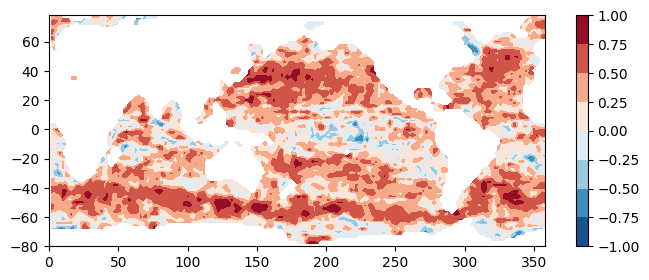

In [10]:
plt.figure(figsize=(8,3))
plt.contourf(lons, lats, coef, cmap='RdBu_r')
plt.colorbar()

### Estimation of computation time higher resolution and more files

The computation for one file computed on a 2 x 2 degree grid takes:

In [11]:
print(str(comptime) + " seconds.")

26.49 seconds.


then assuming linear scaling, processing one file at 0.5 x 0.5 degree resolution would take:

In [12]:
eta_fullres_seconds = comptime*(2/0.5)*(2/0.5)
eta_fullres_minutes = round(eta_fullres_seconds/60)
print(str(eta_fullres_minutes) + " minutes.")

7 minutes.


and for the record over all of 2018 would take:

In [13]:
eta_allfiles_hrs = round( (len(granules_ssh_2018)*eta_fullres_minutes)/60, 1 )
eta_allfiles_days = round(eta_allfiles_hrs/24, 2)
print(str(len(granules_ssh_2018)) + " granules for 2018.")
print(str(eta_allfiles_hrs) + " hours = " + str(eta_allfiles_days) + " days.")

73 granules for 2018.
8.5 hours = 0.35 days.


# Parallelize the computation with Coiled Functions, 
**Run computation at 0.5 x 0.5 degree resolution for year 2018 (73 files)**

In [14]:
# Save output to this local directory:
dir_results = "results/"
os.makedirs(dir_results, exist_ok=True)

In [15]:
# Increased resolution of output grid:
lats = np.arange(-80, 80, 0.5)
lons = np.arange(0, 359, 0.5)

In [16]:
## Perform and time computations!!

t1 = time.time()

# Wrap function in a Coiled function:
    # Faster computations version:
spatial_corrmap_coiled = coiled.function(region="us-west-2", cpu=2, spot_policy="on-demand", shutdown_on_close=True, environ=earthaccess.auth_environ())(spatial_corrmap)
    # Cost-optimized version:
#spatial_corrmap_coiled = coiled.function(region="us-west-2", cpu=1, arm=True, spot_policy="spot_with_fallback", environ=earthaccess.auth_environ())(spatial_corrmap)
spatial_corrmap_coiled.cluster.scale(73)

# Spins up cluster and begin parallel computations:
results = spatial_corrmap_coiled.map(
    granules_ssh_2018, lat_halfwin=3, lon_halfwin=3, 
    lats=lats, lons=lons,
    f_notnull=0.5, 
    )

# Retreives the results from the cluster and saves as .nc files locally:
for (coef, lat, lon), gran in zip(results, granules_ssh_2018):
    # Collect results in an Xarray DataArray:
    da = xr.DataArray(
        data=coef,
        dims=["lat", "lon"],
        coords=dict(lon=lon, lat=lat),
        name='corr_ssh_sst'
        )
    # Then create filename and save:
    date_gran = gran['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR.
    fn_save = dir_results+"spatial-corr-map_ssh-sst_" + date_gran + ".nc"
    da.to_netcdf(fn_save)
    print("Completed " + fn_save)

t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.")

spatial_corrmap_coiled.cluster.scale(1)

Output()

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                                ╷                                                                 │
│   Package                      │ Note                                                            │
│ ╶──────────────────────────────┼───────────────────────────────────────────────────────────────╴ │
│   Babel                        │ https://pypi.org/pypi                                           │
│   Cartopy                      │ https://pypi.org/pypi                                           │
│   Deprecated                   │ https://pypi.org/pypi                                           │
│   Jinja2                       │ https://pypi.org/pypi                                           │
│   MarkupSafe                   │ https://pypi.org/pypi                                           │
│   Pillow                       │ https://pypi.org/pypi                                           │
│   PyNaCl                       │ https://pypi.org/pypi                                           │
│   PyYAML                       │ https://pypi.org/pypi                                           │
│   Pygments                     │ https://pypi.org/pypi                                           │
│   Send2Trash                   │ https://pypi.org/pypi                                           │
│   aiobotocore                  │ https://pypi.org/pypi                                           │
│   aiohttp                      │ https://pypi.org/pypi                                           │
│   aioitertools                 │ https://pypi.org/pypi                                           │
│   aiosignal                    │ https://pypi.org/pypi                                           │
│   anyio                        │ https://pypi.org/pypi                                           │
│   appnope                      │ https://pypi.org/pypi                                           │
│   argon2-cffi                  │ https://pypi.org/pypi                                           │
│   argon2-cffi-bindings         │ https://pypi.org/pypi                                           │
│   arrow                        │ https://pypi.org/pypi                                           │
│   asttokens                    │ https://pypi.org/pypi                                           │
│   async-lru                    │ https://pypi.org/pypi                                           │
│   async-timeout                │ https://pypi.org/pypi                                           │
│   attrs                        │ https://pypi.org/pypi                                           │
│   backcall                     │ https://pypi.org/pypi                                           │
│   backoff                      │ https://pypi.org/pypi                                           │
│   bcrypt                       │ https://pypi.org/pypi                                           │
│   beautifulsoup4               │ https://pypi.org/pypi                                           │
│   bleach                       │ https://pypi.org/pypi                                           │
│   bokeh                        │ https://pypi.org/pypi                                           │
│   boto3                        │ https://pypi.org/pypi                                           │
│   botocore                     │ https://pypi.org/pypi                                           │
│   bounded-pool-executor        │ https://pypi.org/pypi                                           │
│   certifi                      │ https://pypi.org/pypi                                           │
│   cffi                         │ https://pypi.org/pypi                                           │
│   cftime                       │ https://pypi.org/pypi                                           │
│   charset-normalizer           │ https://pypi.org/pypi     

Output()

2024-01-16 22:25:25,010 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=0 maximum=500


Completed results/spatial-corr-map_ssh-sst_20180102.nc
Completed results/spatial-corr-map_ssh-sst_20180107.nc
Completed results/spatial-corr-map_ssh-sst_20180112.nc
Completed results/spatial-corr-map_ssh-sst_20180117.nc
Completed results/spatial-corr-map_ssh-sst_20180122.nc
Completed results/spatial-corr-map_ssh-sst_20180127.nc
Completed results/spatial-corr-map_ssh-sst_20180201.nc
Completed results/spatial-corr-map_ssh-sst_20180206.nc
Completed results/spatial-corr-map_ssh-sst_20180211.nc
Completed results/spatial-corr-map_ssh-sst_20180216.nc
Completed results/spatial-corr-map_ssh-sst_20180221.nc
Completed results/spatial-corr-map_ssh-sst_20180226.nc
Completed results/spatial-corr-map_ssh-sst_20180303.nc
Completed results/spatial-corr-map_ssh-sst_20180308.nc
Completed results/spatial-corr-map_ssh-sst_20180313.nc
Completed results/spatial-corr-map_ssh-sst_20180318.nc
Completed results/spatial-corr-map_ssh-sst_20180323.nc
Completed results/spatial-corr-map_ssh-sst_20180328.nc
Completed 

In [22]:
spatial_corrmap_coiled.cluster.shutdown()

2024-01-16 22:38:22,024 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2024-01-16 22:38:22,189 - distributed.deploy.adaptive_core - INFO - Adaptive stop


## Open and plot results from one of the files

In [17]:
fns_results = os.listdir(dir_results)
testfile = xr.load_dataset(dir_results + fns_results[-1])
testfile

<xarray.Dataset>
Dimensions:       (lon: 718, lat: 320)
Coordinates: (2)
Data variables:
    corr_ssh_sst  (lat, lon) float64 nan nan nan nan ... 0.4275 0.4073 nan nan

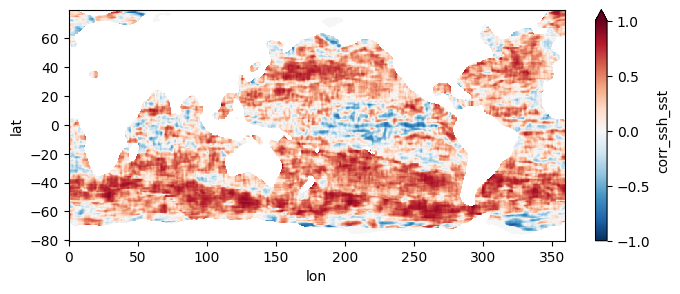

In [18]:
testfile["corr_ssh_sst"].plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')

## Other options

1. Try the following lines of code to switch between manual and auto scaling of the cluster:

In [ ]:
## Try using the manual scaling:
#spatial_corrmap_coiled.cluster.scale(200)
#spatial_corrmap_coiled.cluster.adapt(minimum=X, maximum=Y)

2. Try options to run cluster while minimizing costs: 

In [ ]:
#spatial_corrmap_coiled = coiled.function(region="us-west-2", cpu=1, arm=True, spot_policy="spot_with_fallback", environ=earthaccess.auth_environ())(spatial_corrmap)